In [1]:
from collections.abc import Callable
import numpy as np
import tqdm


class Env:
    TERMINAL_PROB = 0.1

    def __init__(self, n_states: int = 1000, b: int = 1) -> None:
        self.action_space = np.array([0, 1], dtype=np.int32)
        self.terminal_state = n_states
        self.n_states = n_states
        self.b = b

        matrix_size = (n_states, len(self.action_space), b)
        self.transitions = np.random.randint(n_states, size=(matrix_size))
        self.rewards = np.random.randn(*matrix_size)
        self.reset()

    def reset(self):
        self.current_state = 0

    def step(self, action: int):
        if np.random.random() < Env.TERMINAL_PROB:
            return self.terminal_state, 0, True
        next_branch = np.random.randint(self.b)
        next_state = self.transitions[self.current_state, action, next_branch]
        reward = self.rewards[self.current_state, action, next_branch]
        self.current_state = next_state
        return next_state, reward, False


In [2]:
def evaluate_policy_mc(env: Env, Q: np.ndarray, max_eps: int, max_time: int):
    policy = Q.argmax(axis=1)
    state_value = 0
    for ep in range(max_eps):
        env.reset()
        current_state = env.current_state
        sum_reward = 0
        for _ in range(max_time):
            action = policy[current_state]
            next_state, reward, finished = env.step(action)
            if finished:
                break
            sum_reward += reward
            current_state = next_state
        state_value += (sum_reward - state_value) / (ep + 1)
    return state_value


def evaluate_policy(env: Env, Q, state=0, depth=3):
    if depth == 0:
        return np.max(Q[state])

    action = np.argmax(Q[state])
    transitions = env.transitions[state, action]
    rewards = env.rewards[state, action]
    v_transitions = [
        evaluate_policy(env, Q, transition, depth - 1) for transition in transitions
    ]

    value = (1 - env.TERMINAL_PROB) * np.sum(rewards + v_transitions) / env.b
    return value


In [3]:
def uniform(
    env: Env,
    evaluation_method: Callable[[Env, np.ndarray], float],
    max_time: int = 20000,
    evaluation_rate: int = 100,
):
    assert max_time > env.n_states

    history = []
    Q = np.zeros((env.n_states, len(env.action_space)))
    env.reset()
    for t in range(max_time):
        current_state = t // len(env.action_space) % env.n_states
        action = t % len(env.action_space)
        next_states = env.transitions[current_state, action, :]
        Q[current_state, action] = (
            (1 - env.TERMINAL_PROB)
            * np.sum(env.rewards[current_state, action] + Q[next_states, :].max(axis=1))
            / env.b
        )
        if t % evaluation_rate == 0:
            history.append([t, evaluation_method(env, Q)])
    return zip(*history)


In [4]:
def on_policy(
    env: Env,
    evaluation_method: Callable[[Env, np.ndarray], float],
    max_time: int = 20000,
    epsilon: float = 0.1,
    evaluation_rate: int = 100,
):
    history = []
    Q = np.zeros((env.n_states, len(env.action_space)))

    env.reset()
    current_state = env.current_state
    for t in range(max_time):
        action = (
            np.random.choice(env.action_space)
            if np.random.rand() < epsilon
            else int(np.argmax(Q[current_state]))
        )
        next_state, reward, finished = env.step(action)
        next_states = env.transitions[current_state, action, :]
        Q[current_state, action] = (
            (1 - env.TERMINAL_PROB)
            * np.sum(env.rewards[current_state, action] + Q[next_states, :].max(axis=1))
            / env.b
        )

        if finished:
            env.reset()
            current_state = env.current_state
        else:
            current_state = next_state

        if t % evaluation_rate == 0:
            history.append([t, evaluation_method(env, Q)])
    return zip(*history)


100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


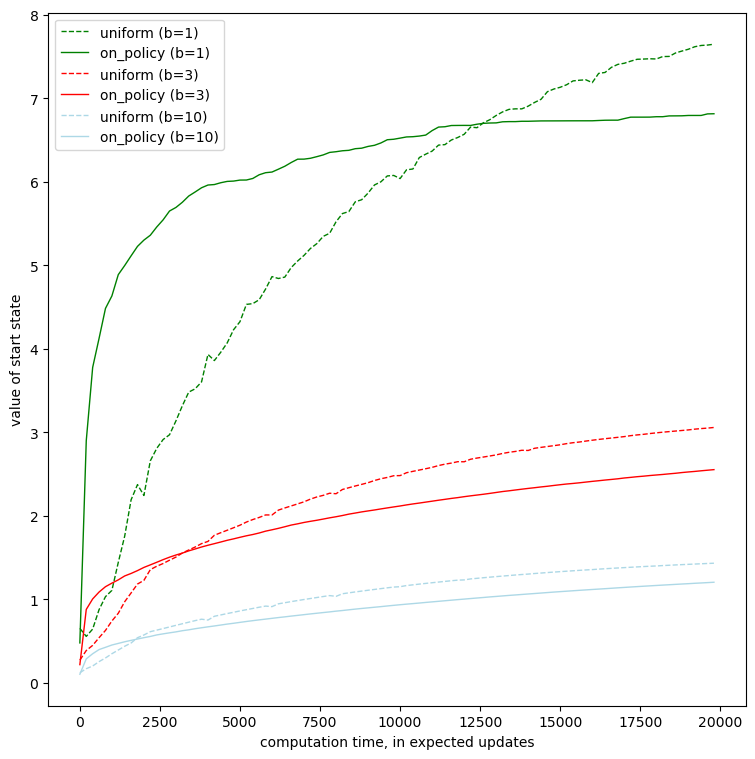

In [5]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = [9, 9]

n_states = 1000
branches = [1, 3, 10]
# branches = [1]
n_runs = 25
max_time = 20000
methods = [uniform, on_policy]
# methods = [uniform]

xticks = 100
colors = ["green", "red", "lightblue"]
linestyles = ["--", "-"]


def evaluation_method(use_mc=False):
    if use_mc:
        return lambda env, Q: evaluate_policy_mc(env, Q, max_eps=1000, max_time=max_time)
    return lambda env, Q: evaluate_policy(env, Q, state=0, depth=3)


for b, color in zip(branches, colors):
    for method, linestyle in zip(methods, linestyles):
        ts, values = None, []
        for _ in tqdm.trange(n_runs):
            env = Env(n_states, b)
            ts, vs = method(
                env,
                evaluation_method=evaluation_method(use_mc=False),
                max_time=max_time,
                evaluation_rate=max_time // xticks,
            )
            values.append(vs)
        plt.plot(
            ts,
            np.mean(values, axis=0),
            linestyle=linestyle,
            linewidth=1,
            label=f"{method.__name__} ({b=:})",
            color=color,
        )

plt.xlabel("computation time, in expected updates")
plt.ylabel("value of start state")
plt.legend()
plt.show()
